In [346]:
from torch_geometric.data import Dataset, DataLoader, Data
from torchvision.io import read_image
from PIL import Image
import torch
import os
import json
import glob
import cv2
import numpy as np
from torch_geometric.nn import GCNConv
from define_path import Def_Path
from sklearn.model_selection import train_test_split
import splitfolders
import shutil
import albumentations as A # Library for augmentations
import networkx as nx
import matplotlib.pyplot as plt 
from torchvision import transforms



In [347]:
# to generalize home directory. User can change their parent path without entering their home directory
path = Def_Path()

parent_path =  path.home + "/Pictures/" + "Data/"

root_dir = parent_path + path.year + "-" + path.month + "-" + path.day + "/"

print(root_dir)

/home/jc-merlab/Pictures/Data/2023-06-27/


In [348]:
class RobotArmDataset(Dataset):
    def __init__(self, root_dir, transform=None, pre_transform=None):
        super(RobotArmDataset, self).__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.imgs_files = sorted(os.listdir(os.path.join(root_dir, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root_dir, "annotations")))
        
    def len(self):
        return len(self.imgs_files)

    def get(self, idx):
        image_file = os.path.join(self.root_dir, "images", self.imgs_files[idx])
        json_file = os.path.join(self.root_dir, "annotations", self.annotations_files[idx])

        with open(json_file, 'r') as f:
            data_json = json.load(f)
        
        keypoints = data_json['keypoints']
        keypoints = [kp[0] for kp in keypoints]  # Extract keypoints from each list

        keypoints = np.array(keypoints).reshape(-1, 3)  # Convert to numpy array and reshape

        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

#         data = {"image": image, "keypoints": keypoints.tolist()}


        if self.transform:
            transformed = self.transform(data)

        keypoints = torch.tensor(keypoints, dtype=torch.float).view(-1, 3)  # Convert back to tensor and reshape
        edge_index = torch.tensor([[i, i+1] for i in range(len(keypoints)-1)], dtype=torch.long).t().contiguous()
        data = Data(x=keypoints, edge_index=edge_index, y=keypoints.clone())
    
        image = torch.from_numpy(image).permute(2, 0, 1).float()  # Convert to PyTorch tensor and rearrange dimensions to (C, H, W)
        return image, data
#         return transformed
        
#     def __getitem__(self, idx):
#         image_file = os.path.join(self.root, "images", self.imgs_files[idx])
#         json_file = os.path.join(self.root, "annotations", self.annotations_files[idx])
    
#         with open(json_file, 'r') as f:
#             data_json = json.load(f)
#         keypoints = data_json['keypoints']
#         keypoints = np.array(keypoints).reshape(-1, 3)  # Convert to numpy array and reshape

#         image = cv2.imread(image_file)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

#         if self.transform:
#             # Transform expects keypoints in format [x, y, visibility]
#             transformed = self.transform(image=image, keypoints=keypoints)
#             image = transformed["image"]
#             keypoints = transformed["keypoints"]

#         keypoints = torch.tensor(keypoints, dtype=torch.float).view(-1, 3)  # Convert back to tensor and reshape
#         edge_index = torch.tensor([[i, i+1] for i in range(len(keypoints)-1)], dtype=torch.long).t().contiguous()
#         data = Data(x=keypoints, edge_index=edge_index)

#         image = torch.from_numpy(image).permute(2, 0, 1).float()  # Convert to PyTorch tensor and rearrange dimensions to (C, H, W)
#         return image, data
    
#     def len(self):
#         return len(self.imgs_files)  # Return the number of data points

#     def get(self, idx):
#         return self.__getitem__(idx)

        

In [349]:
class RotateKeyPoints(object):
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        # rotation of image
        image = image.rotate(self.angle)

        # rotation of keypoints
        rotation_matrix = torch.tensor([
            [torch.cos(self.angle), -torch.sin(self.angle)],
            [torch.sin(self.angle),  torch.cos(self.angle)]
        ])

        keypoints[:, :2] = torch.mm(keypoints[:, :2], rotation_matrix)

        return {'image': image, 'keypoints': keypoints}

In [350]:
def train_transform():
    return transforms.Compose([
    transforms.Lambda(lambda x: Image.fromarray(x)),
    transforms.Resize((640, 480)), 
    transforms.ToTensor(),
    RotateKeyPoints(90),  # Rotate image and keypoints by 90 degrees
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
])

In [351]:
def train_test_split(src_dir):
    dst_dir_img = src_dir + "images"
    dst_dir_anno = src_dir + "annotations"
    
    if os.path.exists(dst_dir_img) and os.path.exists(dst_dir_anno):
        print("folders exist")
    else:
        os.mkdir(dst_dir_img)
        os.mkdir(dst_dir_anno)
        
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir_img)

    for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
        shutil.copy(jsonfile, dst_dir_anno)
        
    output = parent_path + "split_folder_output" + "-" + path.year + "-" + path.month + "-" + path.day 
    
    print(type(output))
    
    splitfolders.ratio(src_dir, # The location of dataset
                   output=output, # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of split dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )
    
    shutil.rmtree(dst_dir_img)
    shutil.rmtree(dst_dir_anno)
    
    return output

In [352]:
def visualize_data(image, data, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    # Remove the channel dimension and convert the tensor back to numpy array
    image_np = image.permute(1, 2, 0).numpy()
    ax.imshow(image_np.astype(int))

    keypoints = data.x[:, :2]  # Assuming the first two dimensions are x and y
    # Create a graph from the edge_index
    G = nx.Graph()
    for i in range(keypoints.shape[0]):
        G.add_node(i, pos=(keypoints[i][0].item(), keypoints[i][1].item()))
    for edge in data.edge_index.t():
        G.add_edge(edge[0].item(), edge[1].item())
    
    # Draw the graph
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, node_color='r', node_size=50, ax=ax)

    plt.show()

<class 'str'>


Copying files: 15462 files [00:00, 18386.10 files/s]


/home/jc-merlab/Pictures/Data/split_folder_output-2023-06-27/train
5411
torch.Size([3, 480, 640])


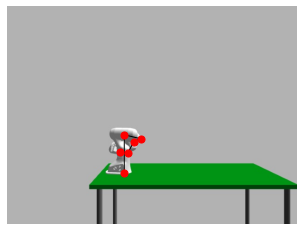

In [353]:
KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/train" 
print(KEYPOINTS_FOLDER_TRAIN)
dataset = RobotArmDataset(KEYPOINTS_FOLDER_TRAIN, transform=None,pre_transform=None)
print(len(dataset))
image, data = dataset[0]
print(image.shape)# Get the first image and its associated data
visualize_data(image, data)

In [354]:
# class RobotArmGCN(torch.nn.Module):
#     def __init__(self):
#         super(RobotArmGCN, self).__init__()
#         self.conv1 = GCNConv(3, 16)
#         self.conv2 = GCNConv(16, 3)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index)
#         x = torch.nn.functional.relu(x)
#         x = self.conv2(x, edge_index)
#         return x

In [355]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/train" #train_test_split(root_dir) +"/train"
KEYPOINTS_FOLDER_VAL = train_test_split(root_dir) +"/val"
KEYPOINTS_FOLDER_TEST = train_test_split(root_dir) +"/test"

dataset_train = RobotArmDataset(KEYPOINTS_FOLDER_TRAIN, transform=None,pre_transform=None)
dataset_val = RobotArmDataset(KEYPOINTS_FOLDER_VAL, transform=None)
dataset_test = RobotArmDataset(KEYPOINTS_FOLDER_TEST, transform=None)

dataloader_train = DataLoader(dataset_train, batch_size=32)
dataloader_test = DataLoader(dataset_test, batch_size=32)
dataloader_val = DataLoader(dataset_val, batch_size=32)

model = RobotArmGCN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)

model.train()
for epoch in range(100):  # Adjust number of epochs as necessary
    for batch in dataloader_train:
        image, data = batch
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = torch.nn.functional.mse_loss(out, data.y)  # Adjust loss function as necessary
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch}, Loss: {loss.item()}')

<class 'str'>


Copying files: 15462 files [00:00, 18408.63 files/s]


<class 'str'>


Copying files: 15462 files [00:00, 18522.20 files/s]


<class 'str'>


Copying files: 15462 files [00:00, 18726.13 files/s]


Epoch: 0, Loss: 50662.9921875
Epoch: 1, Loss: 42015.59375
Epoch: 2, Loss: 35059.1171875
Epoch: 3, Loss: 29456.435546875
Epoch: 4, Loss: 24938.33984375
Epoch: 5, Loss: 21289.828125
Epoch: 6, Loss: 18339.08203125


KeyboardInterrupt: 

In [ ]:
model.eval()
with torch.no_grad():
    for data in your_test_data_loader:  # Replace with your DataLoader
        data = data.to(device)
        output = model(data)
        print(output)

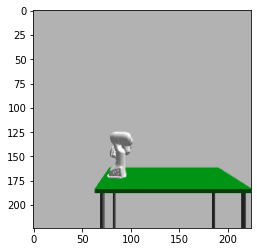

In [177]:
from PIL import Image
import torchvision.transforms as transforms
# from albumentations import Resize, Compose
import albumentations as A
import matplotlib.pyplot as plt

# Load an image
image_path = KEYPOINTS_FOLDER_TRAIN + '/images/000000.rgb.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Define a transformation
# Define a transformation
transform = A.Compose([
    A.Resize(224, 224)
])

# Apply the transformation
transformed = transform(image=image)
transformed_image = transformed["image"]

# Display the transformed image
plt.imshow(transformed_image)
plt.show()